
# Sales Forecasting Analysis - Rossmann Store Sales

This notebook provides a comprehensive analysis of Rossmann store sales data and implements
time series forecasting using Facebook Prophet. The analysis includes data exploration,
preprocessing, visualization, and predictive modeling.

## Dataset Overview
- **train.csv**: Historical sales data for Rossmann stores
- **store.csv**: Store-specific information and features

## Objectives
1. Explore and understand the sales patterns
2. Clean and preprocess the data
3. Perform exploratory data analysis (EDA)
4. Build time series forecasting models
5. Evaluate model performance




# IMPORT LIBRARIES

In [34]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings

# Configure warnings and plotting
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


# DATA LOADING

In [36]:

print("Loading datasets...")

# Load training data
try:
    train_df = pd.read_csv('train.csv')
    print(f"✓ Training data loaded: {train_df.shape}")
except FileNotFoundError:
    print("❌ train.csv not found. Please ensure the file is in the current directory.")

# Load store information
try:
    store_df = pd.read_csv("store.csv")
    print(f"✓ Store data loaded: {store_df.shape}")
except FileNotFoundError:
    print("❌ store.csv not found. Please ensure the file is in the current directory.")


Loading datasets...
✓ Training data loaded: (1017209, 9)
✓ Store data loaded: (1115, 10)


# INITIAL DATA EXPLORATION

In [37]:

print("\n" + "="*60)
print("INITIAL DATA EXPLORATION")
print("="*60)

# Training data overview
print("\n📊 TRAINING DATA OVERVIEW")
print("-" * 30)
print(f"Shape: {train_df.shape}")
print(f"Date range: {train_df['Date'].min()} to {train_df['Date'].max()}")
print("\nFirst 5 rows:")
print(train_df.head())

print("\nData types and info:")
train_df.info()

print("\nStatistical summary:")
print(train_df.describe())


INITIAL DATA EXPLORATION

📊 TRAINING DATA OVERVIEW
------------------------------
Shape: (1017209, 9)
Date range: 2013-01-01 to 2015-07-31

First 5 rows:
   Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1  

Data types and info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-

In [38]:

# Store data overview
print("\n🏪 STORE DATA OVERVIEW")
print("-" * 30)
print(f"Shape: {store_df.shape}")
print(f"Number of unique stores: {store_df['Store'].nunique()}")
print("\nFirst 5 rows:")
print(store_df.head())

print("\nData types and info:")
store_df.info()

print("\nStatistical summary:")
print(store_df.describe())



🏪 STORE DATA OVERVIEW
------------------------------
Shape: (1115, 10)
Number of unique stores: 1115

First 5 rows:
   Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0    

# DATA QUALITY ASSESSMENT

In [39]:
print("\n" + "="*60)
print("DATA QUALITY ASSESSMENT")
print("="*60)

# Check missing values in training data
print("\n🔍 Missing Values in Training Data:")
missing_train = train_df.isnull().sum()
print(missing_train[missing_train > 0])

# Check missing values in store data
print("\n🔍 Missing Values in Store Data:")
missing_store = store_df.isnull().sum()
print(missing_store[missing_store > 0])

# Check data distribution for open/closed stores
closed_stores = len(train_df[train_df['Open'] == 0])
open_stores = len(train_df[train_df['Open'] == 1])
total_records = len(train_df)

print(f"\n📈 Store Status Distribution:")
print(f"Total records: {total_records:,}")
print(f"Closed stores: {closed_stores:,} ({closed_stores/total_records*100:.1f}%)")
print(f"Open stores: {open_stores:,} ({open_stores/total_records*100:.1f}%)")



DATA QUALITY ASSESSMENT

🔍 Missing Values in Training Data:
Series([], dtype: int64)

🔍 Missing Values in Store Data:
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

📈 Store Status Distribution:
Total records: 1,017,209
Closed stores: 172,817 (17.0%)
Open stores: 844,392 (83.0%)


# DATA PREPROCESSING

In [40]:

print("\n" + "="*60)
print("DATA PREPROCESSING")
print("="*60)

# Convert date column to datetime
print("\n🔄 Converting date columns...")
train_df['Date'] = pd.to_datetime(train_df['Date'])

# Handle missing values in store data
print("\n🧹 Handling missing values in store data...")

# Columns to fill with 0 (indicating no promotion/competition info)
promo_competition_cols = ['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
                         'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth']

for col in promo_competition_cols:
    if col in store_df.columns:
        store_df[col].fillna(0, inplace=True)
        print(f"  ✓ Filled {col} with 0")


DATA PREPROCESSING

🔄 Converting date columns...

🧹 Handling missing values in store data...
  ✓ Filled Promo2SinceWeek with 0
  ✓ Filled Promo2SinceYear with 0
  ✓ Filled PromoInterval with 0
  ✓ Filled CompetitionOpenSinceYear with 0
  ✓ Filled CompetitionOpenSinceMonth with 0


In [41]:

# Fill CompetitionDistance with median (more robust than mean)
if 'CompetitionDistance' in store_df.columns:
    median_distance = store_df["CompetitionDistance"].median()
    store_df["CompetitionDistance"].fillna(median_distance, inplace=True)
    print(f"  ✓ Filled CompetitionDistance with median: {median_distance:.0f}")

# Filter for open stores only (sales = 0 when closed)
print(f"\n🏪 Filtering for open stores only...")
print(f"Records before filtering: {len(train_df):,}")
train_df = train_df[train_df['Open'] == 1].copy()
print(f"Records after filtering: {len(train_df):,}")


  ✓ Filled CompetitionDistance with median: 2325

🏪 Filtering for open stores only...
Records before filtering: 1,017,209
Records after filtering: 844,392


In [42]:

# Drop the 'Open' column as it's no longer needed
train_df.drop(['Open'], axis=1, inplace=True)


In [43]:

# Merge datasets
print(f"\n🔗 Merging training and store data...")
df = pd.merge(train_df, store_df, on='Store', how='inner')
print(f"Merged dataset shape: {df.shape}")



🔗 Merging training and store data...
Merged dataset shape: (844392, 17)


In [44]:

# Convert StateHoliday to numeric (handle any non-numeric values)
df['StateHoliday'] = pd.to_numeric(df['StateHoliday'], errors='coerce')
df['StateHoliday'].fillna(0, inplace=True)


In [45]:

# Feature Engineering - Extract date components
print(f"\n⚙️ Engineering date features...")
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['WeekOfYear'] = df['Date'].dt.isocalendar().week
df['Quarter'] = df['Date'].dt.quarter
df['IsWeekend'] = (df['DayOfWeek'] >= 6).astype(int)

# Create competition duration feature
def calculate_competition_duration(row):
    """Calculate months since competition opened"""
    if row['CompetitionOpenSinceYear'] == 0 or row['CompetitionOpenSinceMonth'] == 0:
        return 0
    try:
        comp_date = pd.datetime(int(row['CompetitionOpenSinceYear']),
                               int(row['CompetitionOpenSinceMonth']), 1)
        return (row['Date'] - comp_date).days / 30.44  # Average days per month
    except:
        return 0

df['CompetitionDuration'] = df.apply(calculate_competition_duration, axis=1)
df['CompetitionDuration'] = df['CompetitionDuration'].clip(lower=0)

print("  ✓ Added Year, Month, Day, WeekOfYear, Quarter, IsWeekend")
print("  ✓ Added CompetitionDuration")

print(f"\n📋 Final dataset shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")



⚙️ Engineering date features...
  ✓ Added Year, Month, Day, WeekOfYear, Quarter, IsWeekend
  ✓ Added CompetitionDuration

📋 Final dataset shape: (844392, 24)
Date range: 2013-01-01 00:00:00 to 2015-07-31 00:00:00


# EXPLORATORY DATA ANALYSIS


EXPLORATORY DATA ANALYSIS

📊 Creating distribution plots...


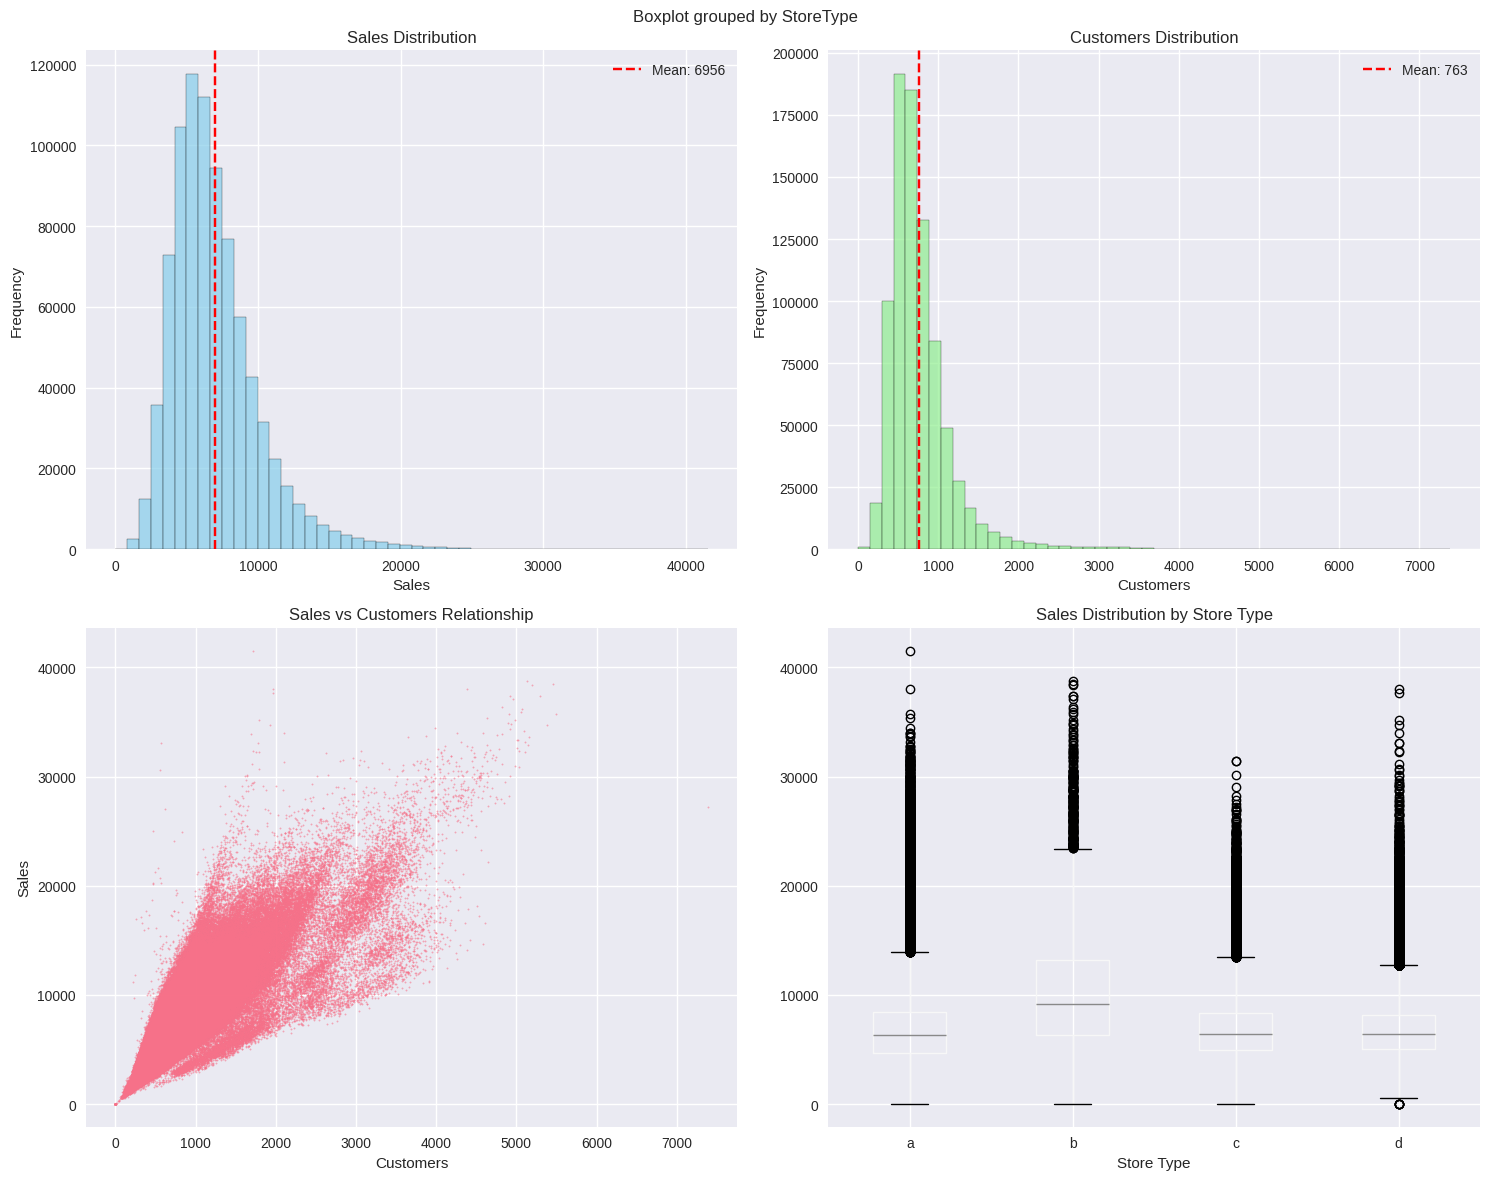

In [47]:

print("\n" + "="*60)
print("EXPLORATORY DATA ANALYSIS")
print("="*60)

# Set up plotting parameters
plt.rcParams['figure.figsize'] = (12, 8)

# 1. Distribution Analysis
print("\n📊 Creating distribution plots...")

# Sales and customer distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Distribution Analysis', fontsize=16, fontweight='bold')

# Sales distribution
axes[0,0].hist(df['Sales'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Sales Distribution')
axes[0,0].set_xlabel('Sales')
axes[0,0].set_ylabel('Frequency')
axes[0,0].axvline(df['Sales'].mean(), color='red', linestyle='--',
                  label=f'Mean: {df["Sales"].mean():.0f}')
axes[0,0].legend()

# Customers distribution
axes[0,1].hist(df['Customers'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].set_title('Customers Distribution')
axes[0,1].set_xlabel('Customers')
axes[0,1].set_ylabel('Frequency')
axes[0,1].axvline(df['Customers'].mean(), color='red', linestyle='--',
                  label=f'Mean: {df["Customers"].mean():.0f}')
axes[0,1].legend()

# Sales vs Customers scatter
axes[1,0].scatter(df['Customers'], df['Sales'], alpha=0.5, s=1)
axes[1,0].set_title('Sales vs Customers Relationship')
axes[1,0].set_xlabel('Customers')
axes[1,0].set_ylabel('Sales')

# Sales by Store Type
df.boxplot(column='Sales', by='StoreType', ax=axes[1,1])
axes[1,1].set_title('Sales Distribution by Store Type')
axes[1,1].set_xlabel('Store Type')

plt.tight_layout()
plt.show()



📈 Creating temporal analysis plots...


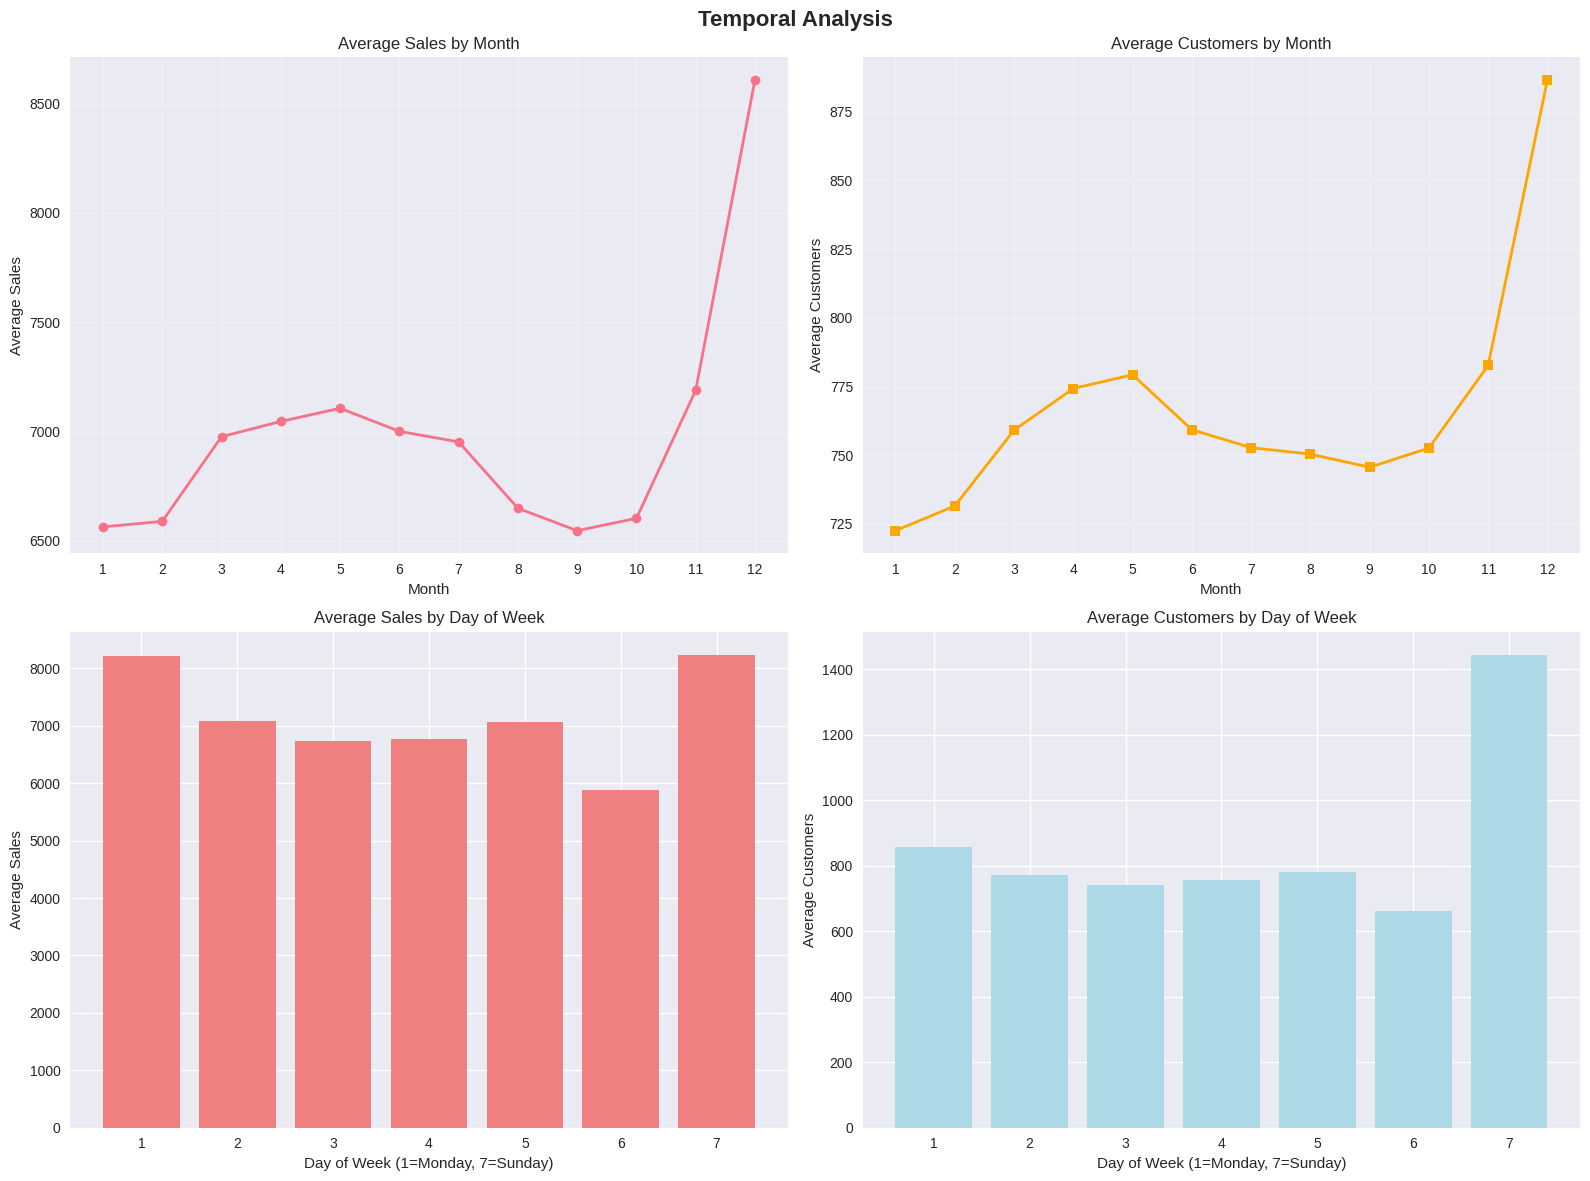

In [48]:

# 2. Temporal Analysis
print("\n📈 Creating temporal analysis plots...")

# Monthly trends
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Temporal Analysis', fontsize=16, fontweight='bold')

# Average sales by month
monthly_sales = df.groupby('Month')[['Sales']].mean()
axes[0,0].plot(monthly_sales.index, monthly_sales['Sales'], marker='o', linewidth=2)
axes[0,0].set_title('Average Sales by Month')
axes[0,0].set_xlabel('Month')
axes[0,0].set_ylabel('Average Sales')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].set_xticks(range(1, 13))

# Average customers by month
monthly_customers = df.groupby('Month')[['Customers']].mean()
axes[0,1].plot(monthly_customers.index, monthly_customers['Customers'],
               marker='s', linewidth=2, color='orange')
axes[0,1].set_title('Average Customers by Month')
axes[0,1].set_xlabel('Month')
axes[0,1].set_ylabel('Average Customers')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].set_xticks(range(1, 13))

# Sales by day of week
dow_sales = df.groupby('DayOfWeek')[['Sales']].mean()
axes[1,0].bar(dow_sales.index, dow_sales['Sales'], color='lightcoral')
axes[1,0].set_title('Average Sales by Day of Week')
axes[1,0].set_xlabel('Day of Week (1=Monday, 7=Sunday)')
axes[1,0].set_ylabel('Average Sales')

# Customers by day of week
dow_customers = df.groupby('DayOfWeek')[['Customers']].mean()
axes[1,1].bar(dow_customers.index, dow_customers['Customers'], color='lightblue')
axes[1,1].set_title('Average Customers by Day of Week')
axes[1,1].set_xlabel('Day of Week (1=Monday, 7=Sunday)')
axes[1,1].set_ylabel('Average Customers')

plt.tight_layout()
plt.show()



🎯 Creating promotion impact analysis...


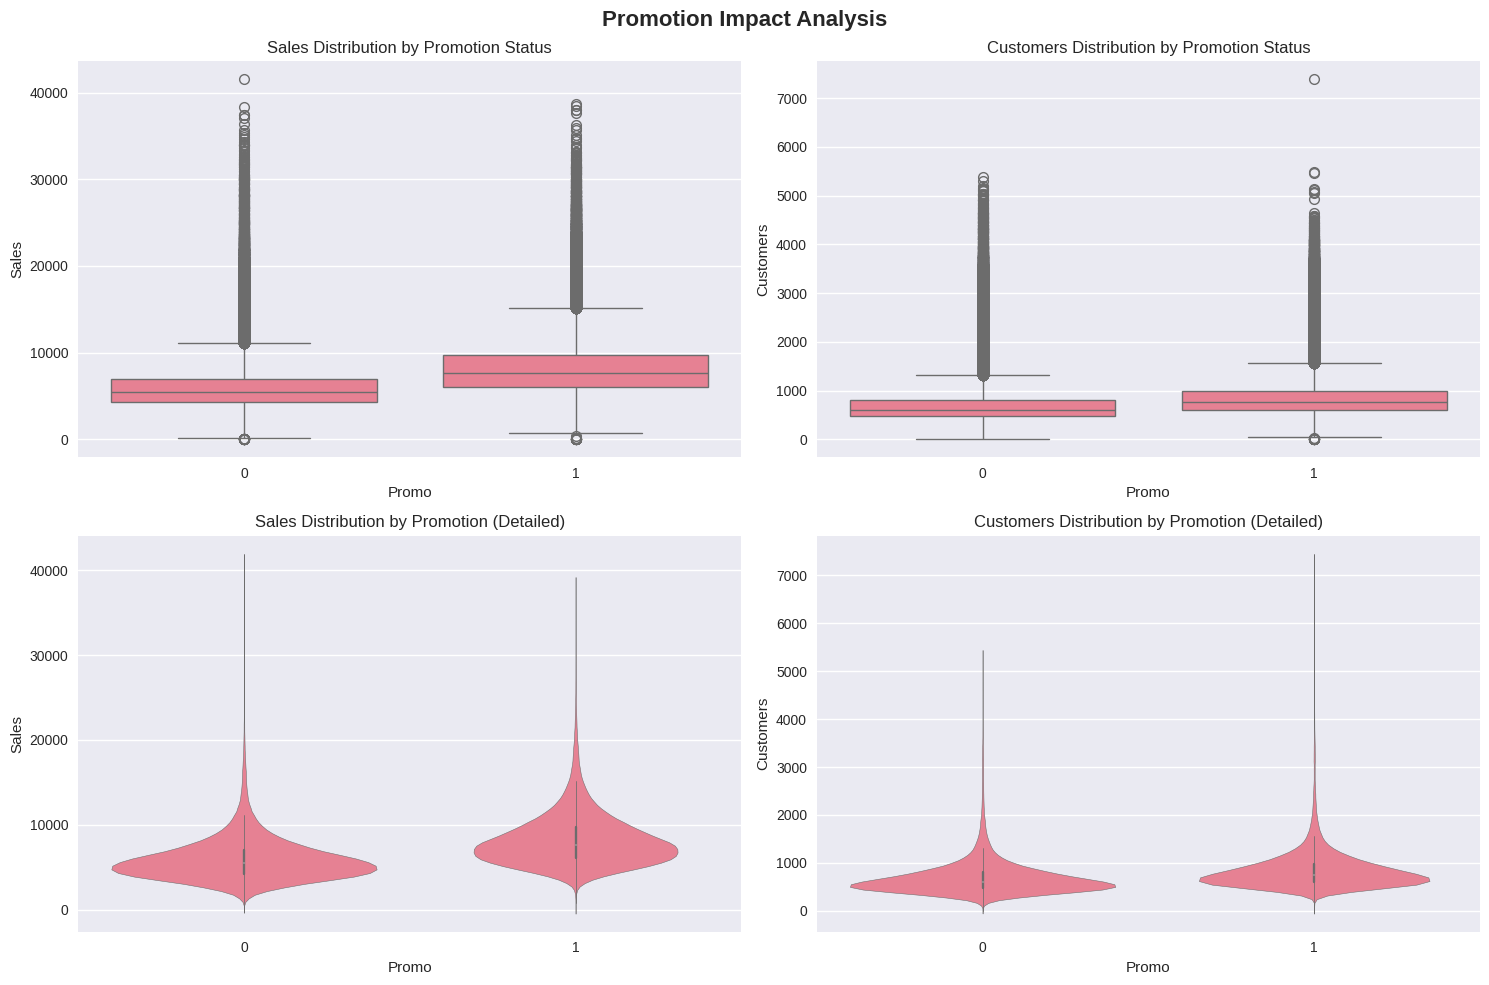

In [49]:

# 3. Promotion Analysis
print("\n🎯 Creating promotion impact analysis...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Promotion Impact Analysis', fontsize=16, fontweight='bold')

# Sales by promotion status
sns.boxplot(x='Promo', y='Sales', data=df, ax=axes[0,0])
axes[0,0].set_title('Sales Distribution by Promotion Status')

# Customers by promotion status
sns.boxplot(x='Promo', y='Customers', data=df, ax=axes[0,1])
axes[0,1].set_title('Customers Distribution by Promotion Status')

# Violin plots for more detailed distribution
sns.violinplot(x='Promo', y='Sales', data=df, ax=axes[1,0])
axes[1,0].set_title('Sales Distribution by Promotion (Detailed)')

sns.violinplot(x='Promo', y='Customers', data=df, ax=axes[1,1])
axes[1,1].set_title('Customers Distribution by Promotion (Detailed)')

plt.tight_layout()
plt.show()



🔗 Creating correlation analysis...


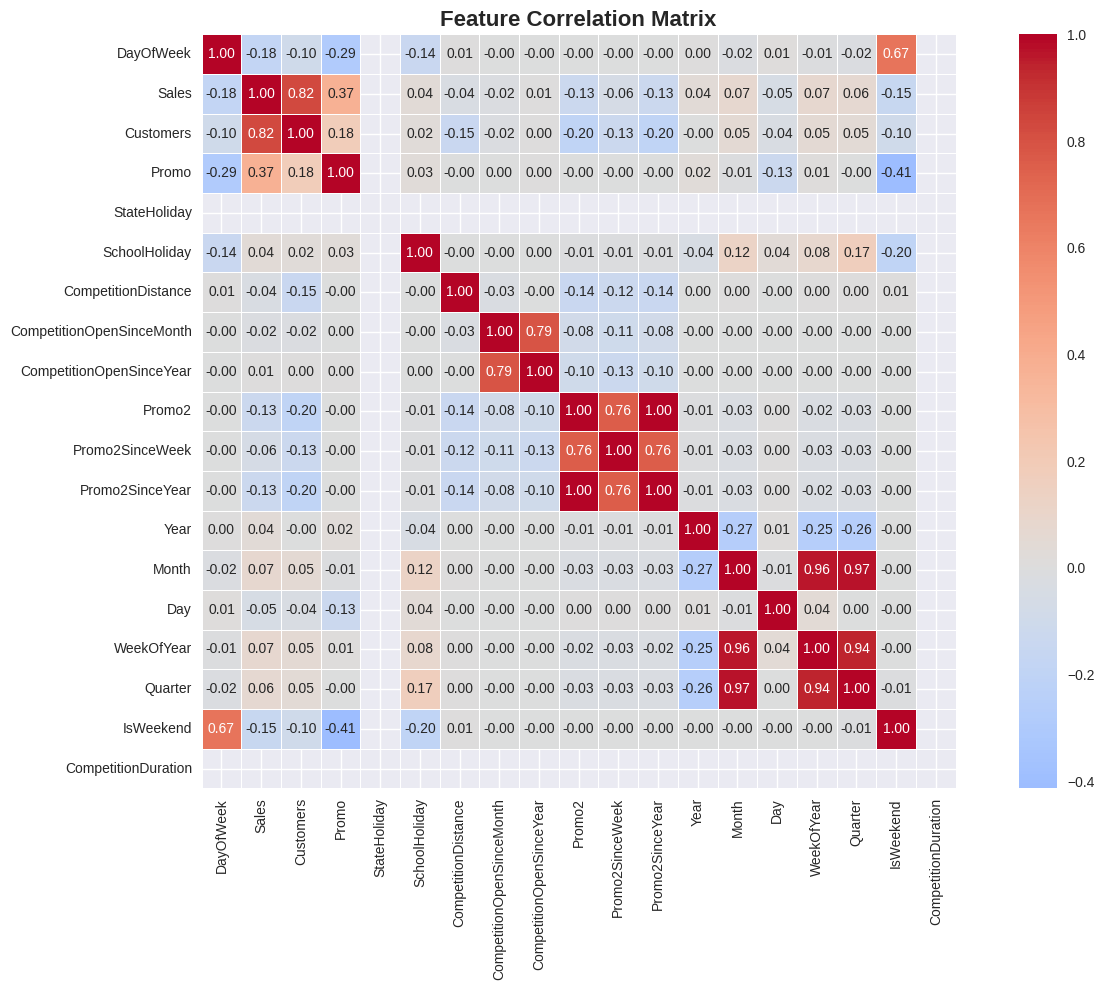

In [50]:

# 4. Correlation Analysis
print("\n🔗 Creating correlation analysis...")

# Select numerical columns for correlation
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Remove date-related columns that might not be meaningful for correlation
exclude_cols = ['Store', 'Date']
numerical_cols = [col for col in numerical_cols if col not in exclude_cols]

# Create correlation matrix
correlation_matrix = df[numerical_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, fmt='.2f')
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


🏪 Creating store performance analysis...


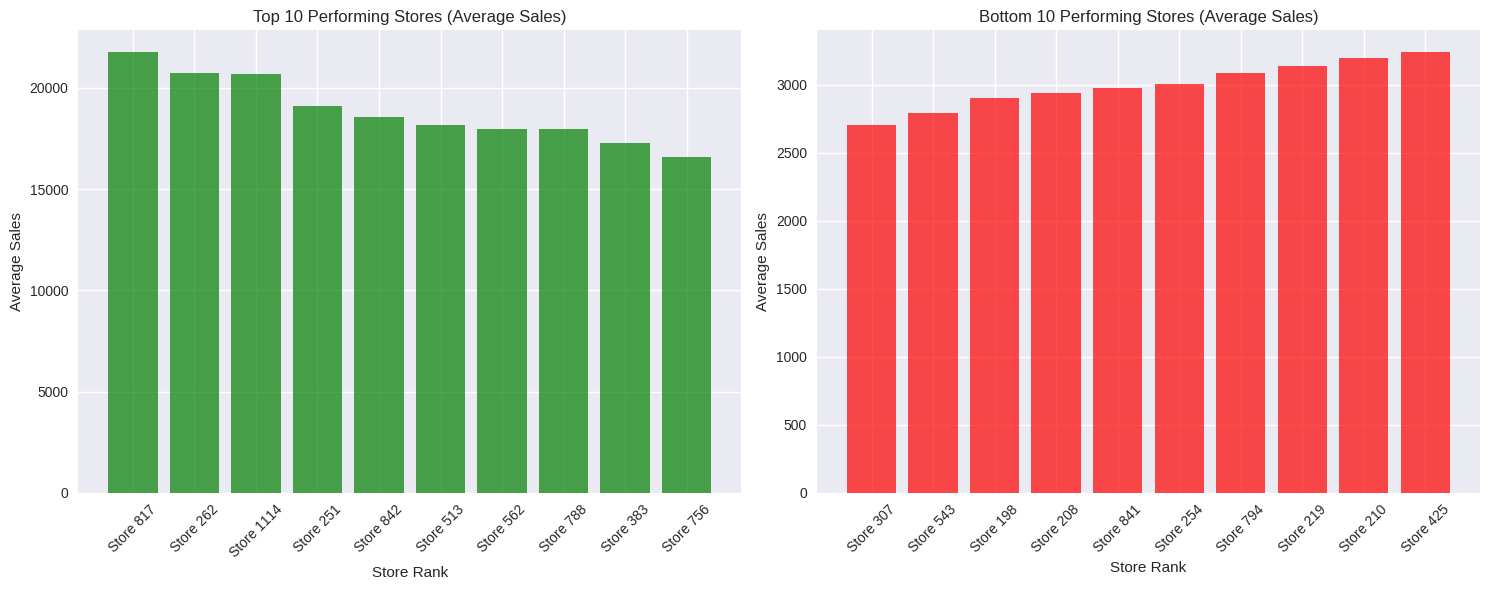


Top performing store: 817 (Avg Sales: 21757)
Lowest performing store: 307 (Avg Sales: 2704)


In [51]:

# 5. Store Performance Analysis
print("\n🏪 Creating store performance analysis...")

# Top performing stores
top_stores = df.groupby('Store')['Sales'].mean().sort_values(ascending=False).head(10)
bottom_stores = df.groupby('Store')['Sales'].mean().sort_values(ascending=True).head(10)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].bar(range(len(top_stores)), top_stores.values, color='green', alpha=0.7)
axes[0].set_title('Top 10 Performing Stores (Average Sales)')
axes[0].set_xlabel('Store Rank')
axes[0].set_ylabel('Average Sales')
axes[0].set_xticks(range(len(top_stores)))
axes[0].set_xticklabels([f'Store {x}' for x in top_stores.index], rotation=45)

axes[1].bar(range(len(bottom_stores)), bottom_stores.values, color='red', alpha=0.7)
axes[1].set_title('Bottom 10 Performing Stores (Average Sales)')
axes[1].set_xlabel('Store Rank')
axes[1].set_ylabel('Average Sales')
axes[1].set_xticks(range(len(bottom_stores)))
axes[1].set_xticklabels([f'Store {x}' for x in bottom_stores.index], rotation=45)

plt.tight_layout()
plt.show()

print(f"\nTop performing store: {top_stores.index[0]} (Avg Sales: {top_stores.iloc[0]:.0f})")
print(f"Lowest performing store: {bottom_stores.index[0]} (Avg Sales: {bottom_stores.iloc[0]:.0f})")


# TIME SERIES FORECASTING WITH PROPHET


In [52]:

print("\n" + "="*60)
print("TIME SERIES FORECASTING")
print("="*60)

# Install Prophet if not already installed
try:
    from prophet import Prophet
    print("✓ Prophet library loaded successfully")
except ImportError:
    print("Installing Prophet...")
    import subprocess
    subprocess.check_call(["pip", "install", "prophet"])
    from prophet import Prophet
    print("✓ Prophet library installed and loaded")

def prepare_prophet_data(store_data):
    """
    Prepare data for Prophet model

    Args:
        store_data: DataFrame with Date and Sales columns

    Returns:
        DataFrame with 'ds' and 'y' columns for Prophet
    """
    prophet_df = store_data[['Date', 'Sales']].copy()
    prophet_df = prophet_df.rename(columns={'Date': 'ds', 'Sales': 'y'})
    prophet_df = prophet_df.sort_values('ds').reset_index(drop=True)

    # Remove any duplicate dates by averaging
    prophet_df = prophet_df.groupby('ds')['y'].mean().reset_index()

    return prophet_df


TIME SERIES FORECASTING
✓ Prophet library loaded successfully


In [53]:

def create_holidays_df(df):
    """
    Create holidays dataframe for Prophet model

    Args:
        df: Main dataframe

    Returns:
        DataFrame with holiday information
    """
    # School holidays
    school_holidays = df[df['SchoolHoliday'] == 1]['Date'].drop_duplicates()
    school_holidays_df = pd.DataFrame({
        'ds': school_holidays,
        'holiday': 'school_holiday'
    })

    # State holidays (assuming StateHoliday == 1 indicates a holiday)
    state_holidays = df[df['StateHoliday'] == 1]['Date'].drop_duplicates()
    state_holidays_df = pd.DataFrame({
        'ds': state_holidays,
        'holiday': 'state_holiday'
    })

    # Combine holidays
    holidays_df = pd.concat([school_holidays_df, state_holidays_df], ignore_index=True)
    holidays_df = holidays_df.drop_duplicates().reset_index(drop=True)

    return holidays_df

In [57]:

def sales_prediction_with_validation(store_id, df, holidays_df, forecast_periods=60):
    """
    Enhanced sales prediction function with model validation

    Args:
        store_id: Store ID to forecast
        df: Main dataframe
        holidays_df: Holidays dataframe
        forecast_periods: Number of periods to forecast

    Returns:
        Dictionary with model performance metrics
    """
    print(f"\n🔮 Forecasting for Store {store_id}")
    print("-" * 40)

    # Filter data for specific store
    store_data = df[df['Store'] == store_id].copy()

    if len(store_data) < 30:  # Need sufficient data
        print(f"❌ Insufficient data for store {store_id} ({len(store_data)} records)")
        return None

    print(f"📊 Data points available: {len(store_data)}")
    print(f"📅 Date range: {store_data['Date'].min()} to {store_data['Date'].max()}")

    # Prepare data for Prophet
    prophet_data = prepare_prophet_data(store_data)

    # Split data for validation (use last 30 days as test set)
    train_cutoff = prophet_data['ds'].max() - timedelta(days=30)
    train_data = prophet_data[prophet_data['ds'] <= train_cutoff].copy()
    test_data = prophet_data[prophet_data['ds'] > train_cutoff].copy()

    print(f"📈 Training data: {len(train_data)} points")
    print(f"📉 Test data: {len(test_data)} points")

    # Initialize and train Prophet model
    model = Prophet(
        holidays=holidays_df,
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode='multiplicative',
        interval_width=0.95
    )

    print("🤖 Training Prophet model...")
    model.fit(train_data)

    # Create future dataframe for validation
    future_validation = model.make_future_dataframe(periods=len(test_data), freq='D')
    forecast_validation = model.predict(future_validation)

    # Calculate validation metrics
    if len(test_data) > 0:
        test_forecast = forecast_validation.tail(len(test_data))

        mae = mean_absolute_error(test_data['y'], test_forecast['yhat'])
        rmse = np.sqrt(mean_squared_error(test_data['y'], test_forecast['yhat']))
        mape = np.mean(np.abs((test_data['y'] - test_forecast['yhat']) / test_data['y'])) * 100

        print(f"📊 Validation Metrics:")
        print(f"  MAE:  {mae:.2f}")
        print(f"  RMSE: {rmse:.2f}")
        print(f"  MAPE: {mape:.2f}%")

    # Create forecast for specified periods
    future_forecast = model.make_future_dataframe(periods=forecast_periods, freq='D')
    forecast = model.predict(future_forecast)

    # Plot results
    fig, axes = plt.subplots(2, 1, figsize=(15, 12))

    # Main forecast plot
    model.plot(forecast, ax=axes[0])
    axes[0].set_title(f'Sales Forecast for Store {store_id}', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Sales')

    # Add validation period shading
    if len(test_data) > 0:
        axes[0].axvspan(test_data['ds'].min(), test_data['ds'].max(),
                       alpha=0.2, color='red', label='Validation Period')
        axes[0].legend()

    # Components plot
    model.plot_components(forecast)

    plt.tight_layout()
    plt.show()

    # Return summary statistics
    forecast_summary = {
        'store_id': store_id,
        'data_points': len(store_data),
        'forecast_mean': forecast['yhat'].tail(forecast_periods).mean(),
        'forecast_std': forecast['yhat'].tail(forecast_periods).std(),
        'validation_mae': mae if len(test_data) > 0 else None,
        'validation_rmse': rmse if len(test_data) > 0 else None,
        'validation_mape': mape if len(test_data) > 0 else None
    }

    return forecast_summary

DEBUG:cmdstanpy:input tempfile: /tmp/tmprxxoul9p/84zg2mv0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxxoul9p/jg3q2szh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10363', 'data', 'file=/tmp/tmprxxoul9p/84zg2mv0.json', 'init=/tmp/tmprxxoul9p/jg3q2szh.json', 'output', 'file=/tmp/tmprxxoul9p/prophet_modelsajaub55/prophet_model-20250719215820.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:58:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



🎄 Preparing holidays data...
✓ Created holidays dataframe with 477 holiday dates

🔮 Forecasting for Store 1
----------------------------------------
📊 Data points available: 781
📅 Date range: 2013-01-02 00:00:00 to 2015-07-31 00:00:00
📈 Training data: 755 points
📉 Test data: 26 points
🤖 Training Prophet model...


21:58:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


📊 Validation Metrics:
  MAE:  596.16
  RMSE: 746.23
  MAPE: 13.78%


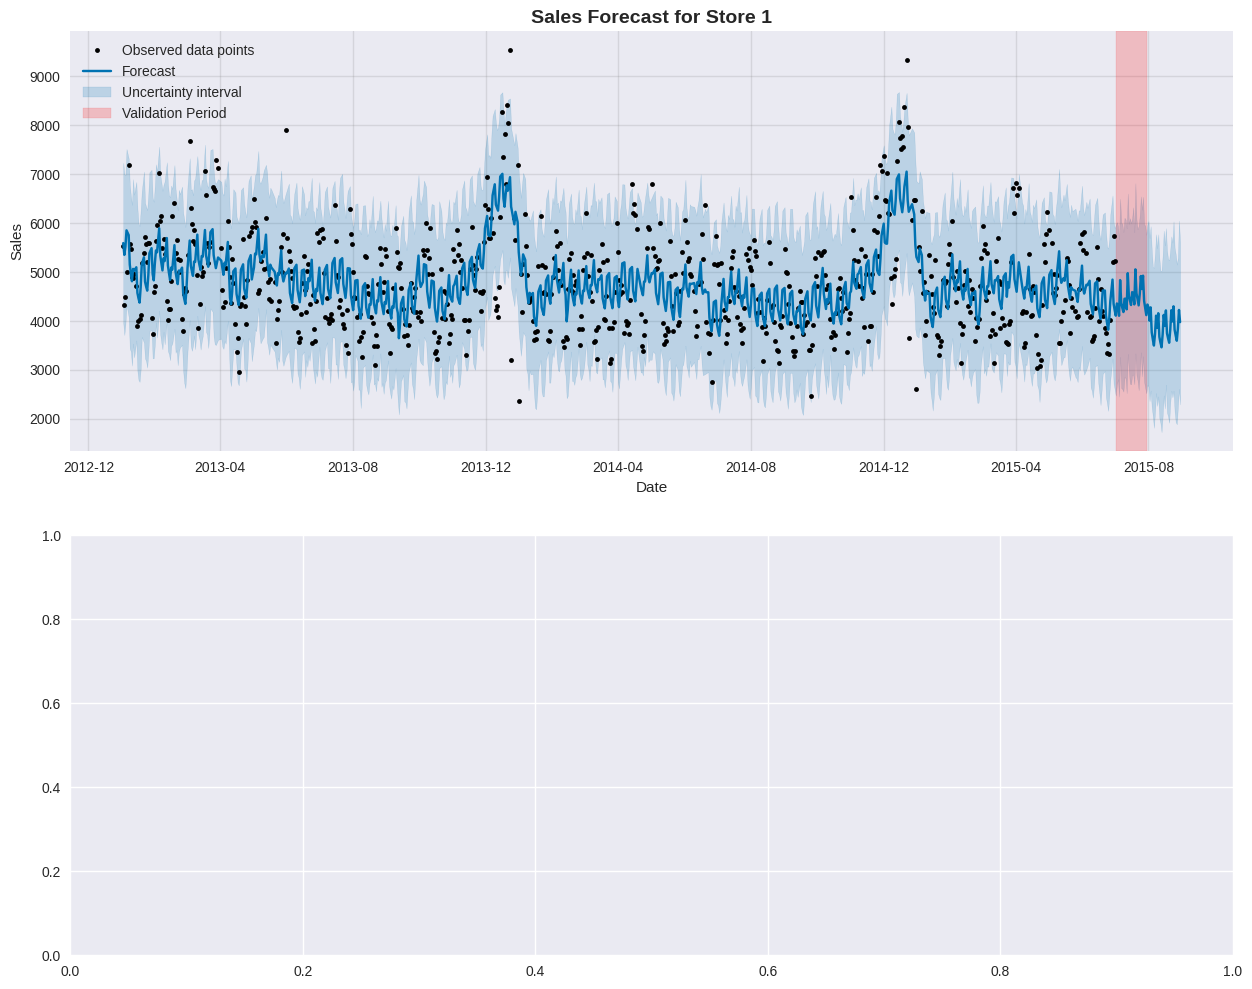

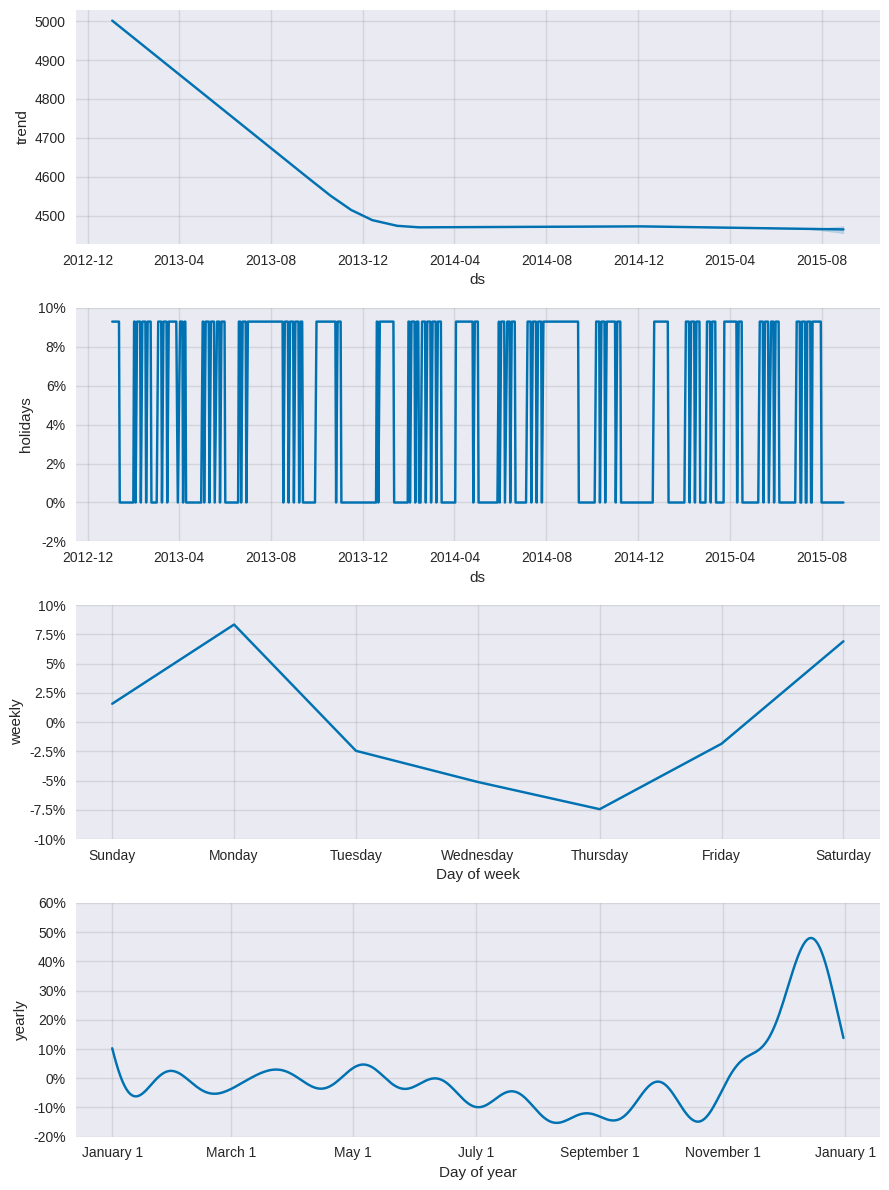

DEBUG:cmdstanpy:input tempfile: /tmp/tmprxxoul9p/f7_q4pwy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxxoul9p/ssixmqlr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17404', 'data', 'file=/tmp/tmprxxoul9p/f7_q4pwy.json', 'init=/tmp/tmprxxoul9p/ssixmqlr.json', 'output', 'file=/tmp/tmprxxoul9p/prophet_modelcfwb9wbw/prophet_model-20250719215822.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:58:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



🔮 Forecasting for Store 10
----------------------------------------
📊 Data points available: 784
📅 Date range: 2013-01-02 00:00:00 to 2015-07-31 00:00:00
📈 Training data: 758 points
📉 Test data: 26 points
🤖 Training Prophet model...


21:58:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


📊 Validation Metrics:
  MAE:  637.08
  RMSE: 850.61
  MAPE: 10.76%


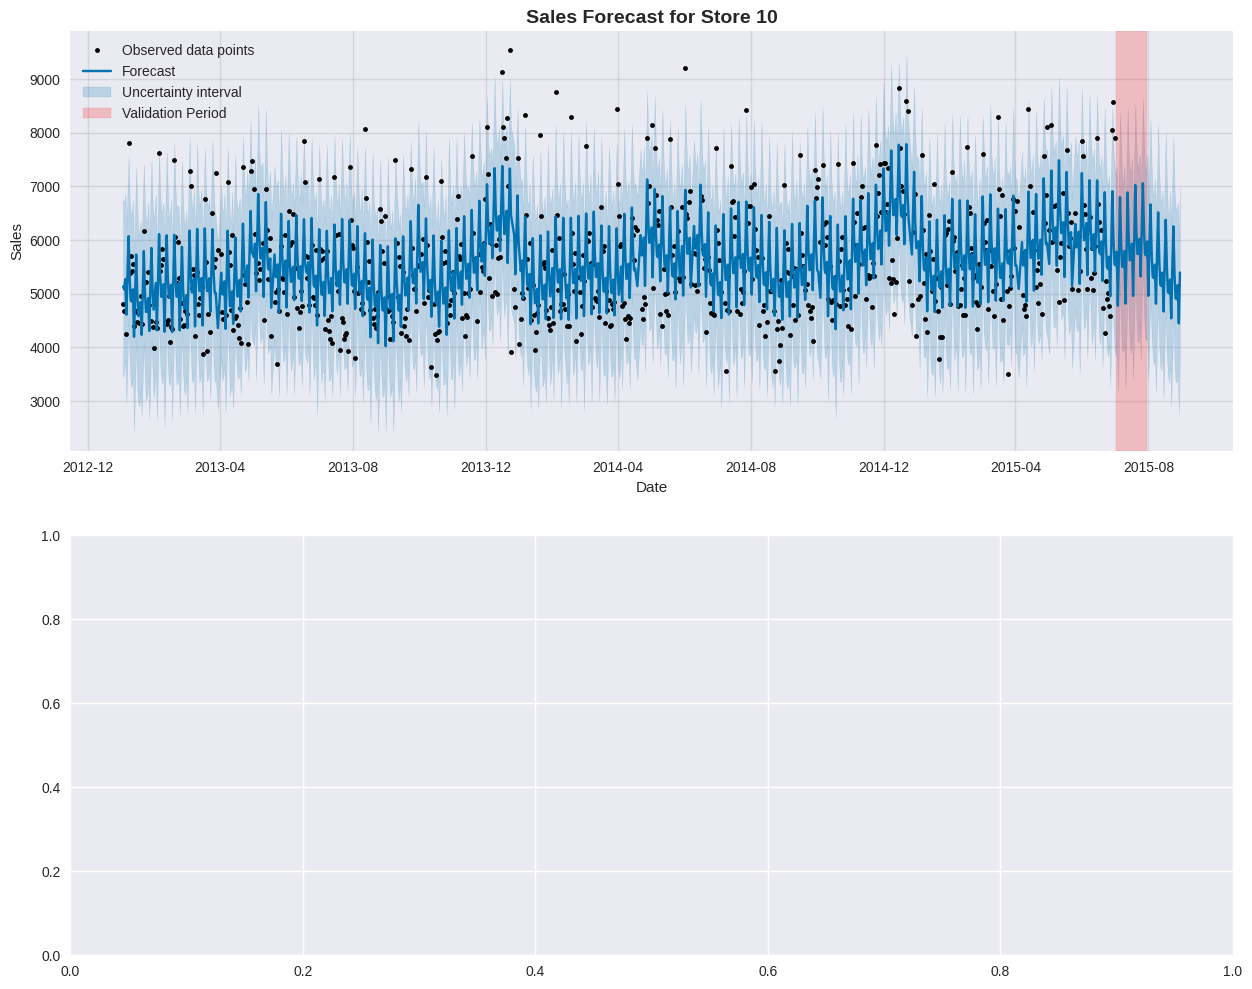

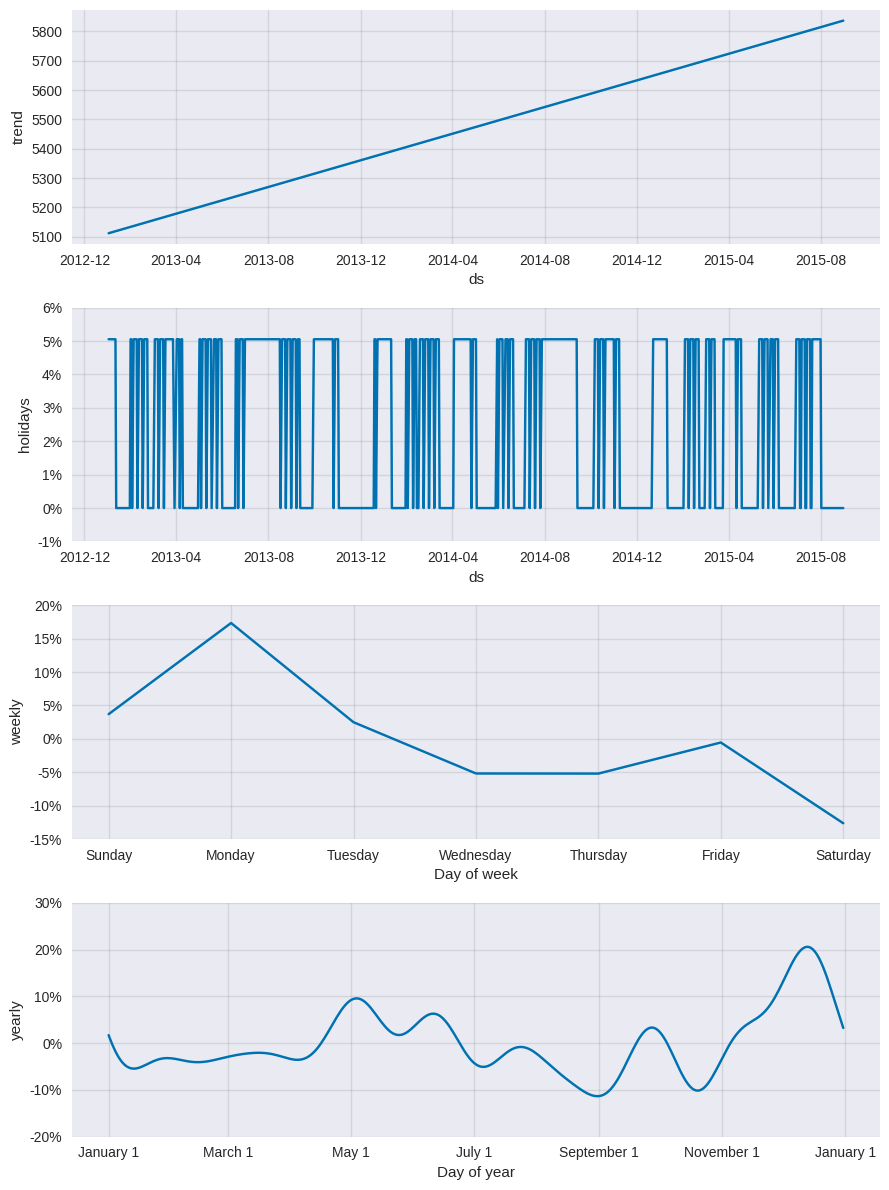

DEBUG:cmdstanpy:input tempfile: /tmp/tmprxxoul9p/9pz_2c1j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxxoul9p/6n46f8xp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77820', 'data', 'file=/tmp/tmprxxoul9p/9pz_2c1j.json', 'init=/tmp/tmprxxoul9p/6n46f8xp.json', 'output', 'file=/tmp/tmprxxoul9p/prophet_modele_c5_2f5/prophet_model-20250719215823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:58:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



🔮 Forecasting for Store 25
----------------------------------------
📊 Data points available: 752
📅 Date range: 2013-01-02 00:00:00 to 2015-07-31 00:00:00
📈 Training data: 726 points
📉 Test data: 26 points
🤖 Training Prophet model...


21:58:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


📊 Validation Metrics:
  MAE:  1739.33
  RMSE: 2134.22
  MAPE: 18.45%


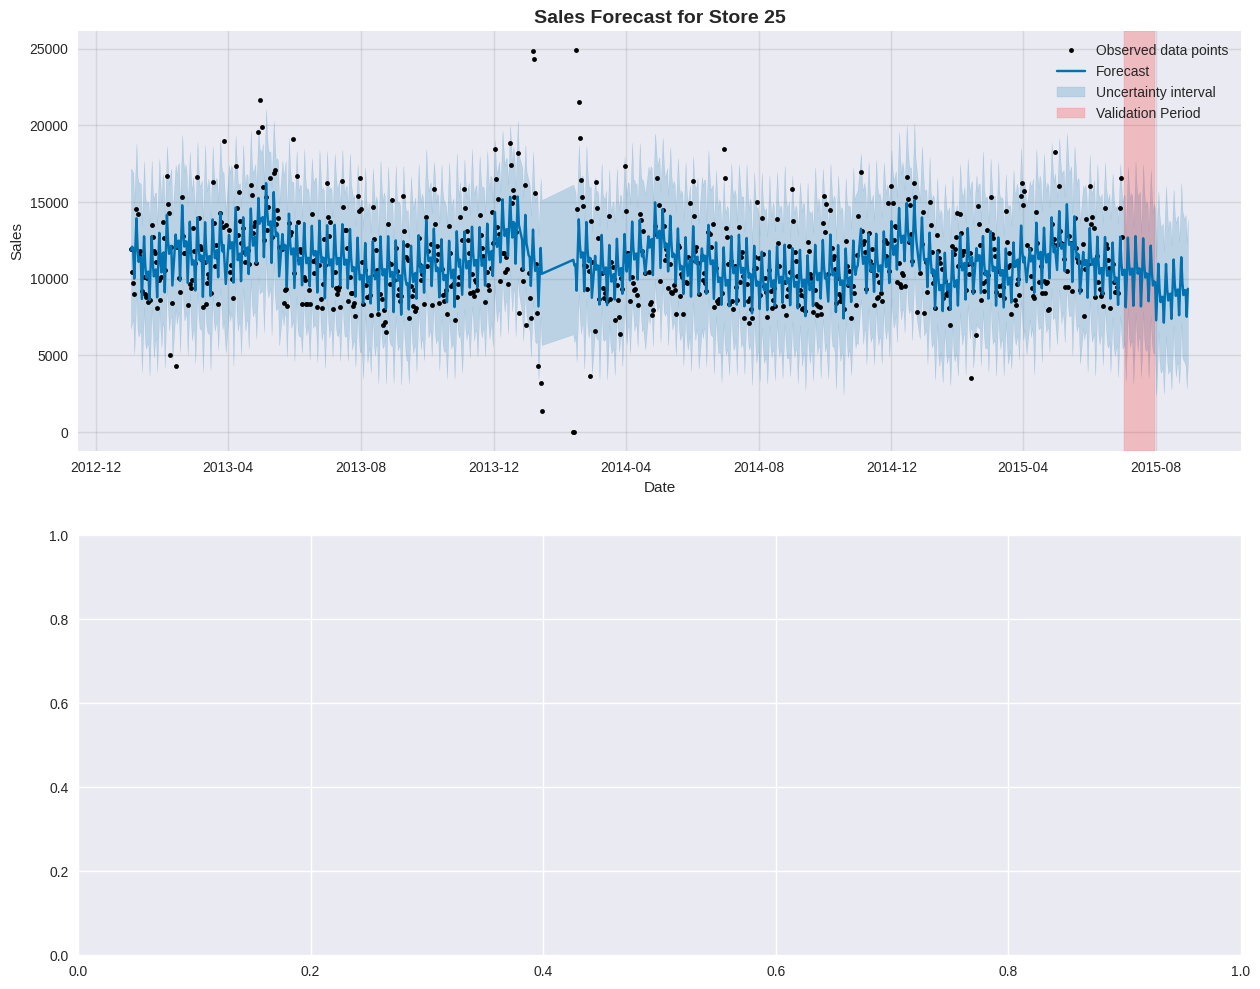

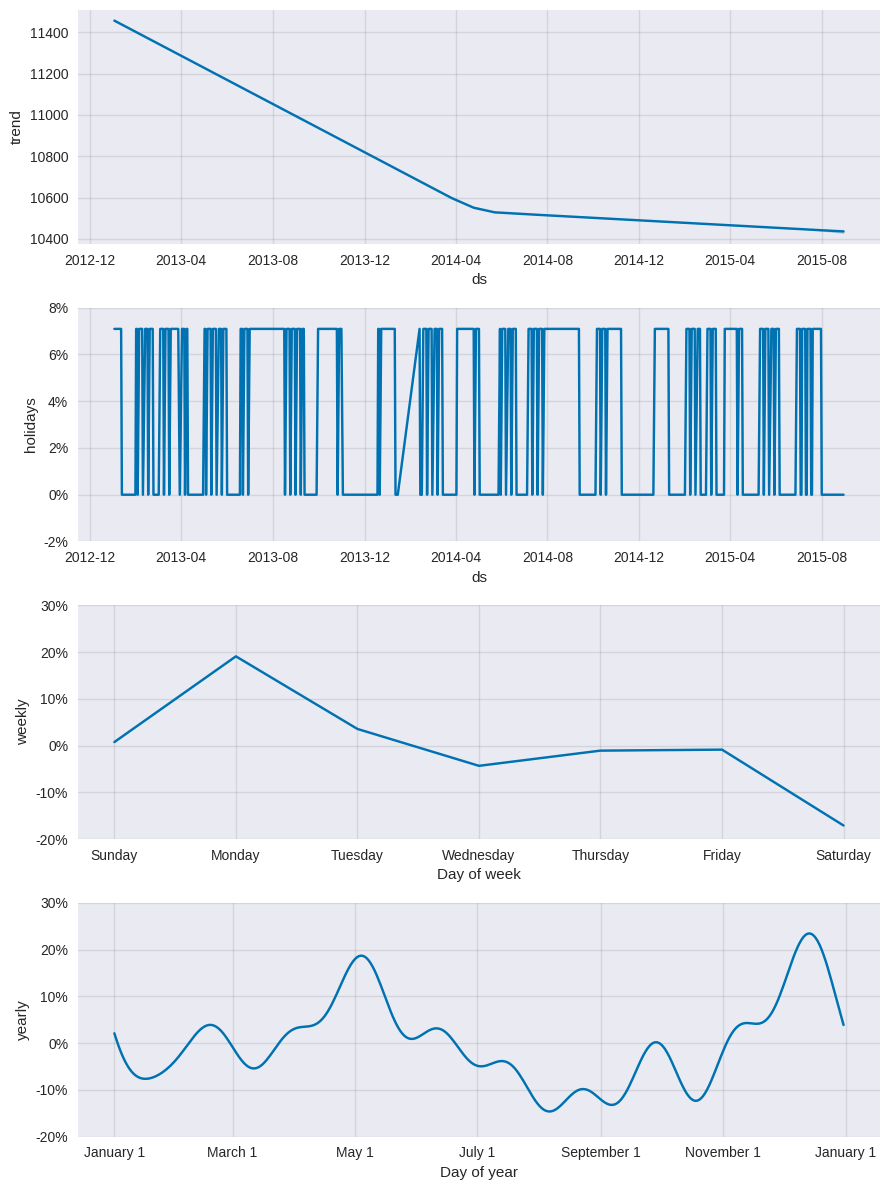

DEBUG:cmdstanpy:input tempfile: /tmp/tmprxxoul9p/_743tnja.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxxoul9p/u0ipm68v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10542', 'data', 'file=/tmp/tmprxxoul9p/_743tnja.json', 'init=/tmp/tmprxxoul9p/u0ipm68v.json', 'output', 'file=/tmp/tmprxxoul9p/prophet_modelzd87xlv9/prophet_model-20250719215825.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:58:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



🔮 Forecasting for Store 50
----------------------------------------
📊 Data points available: 779
📅 Date range: 2013-01-02 00:00:00 to 2015-07-31 00:00:00
📈 Training data: 753 points
📉 Test data: 26 points
🤖 Training Prophet model...


21:58:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


📊 Validation Metrics:
  MAE:  816.36
  RMSE: 1099.53
  MAPE: 18.20%


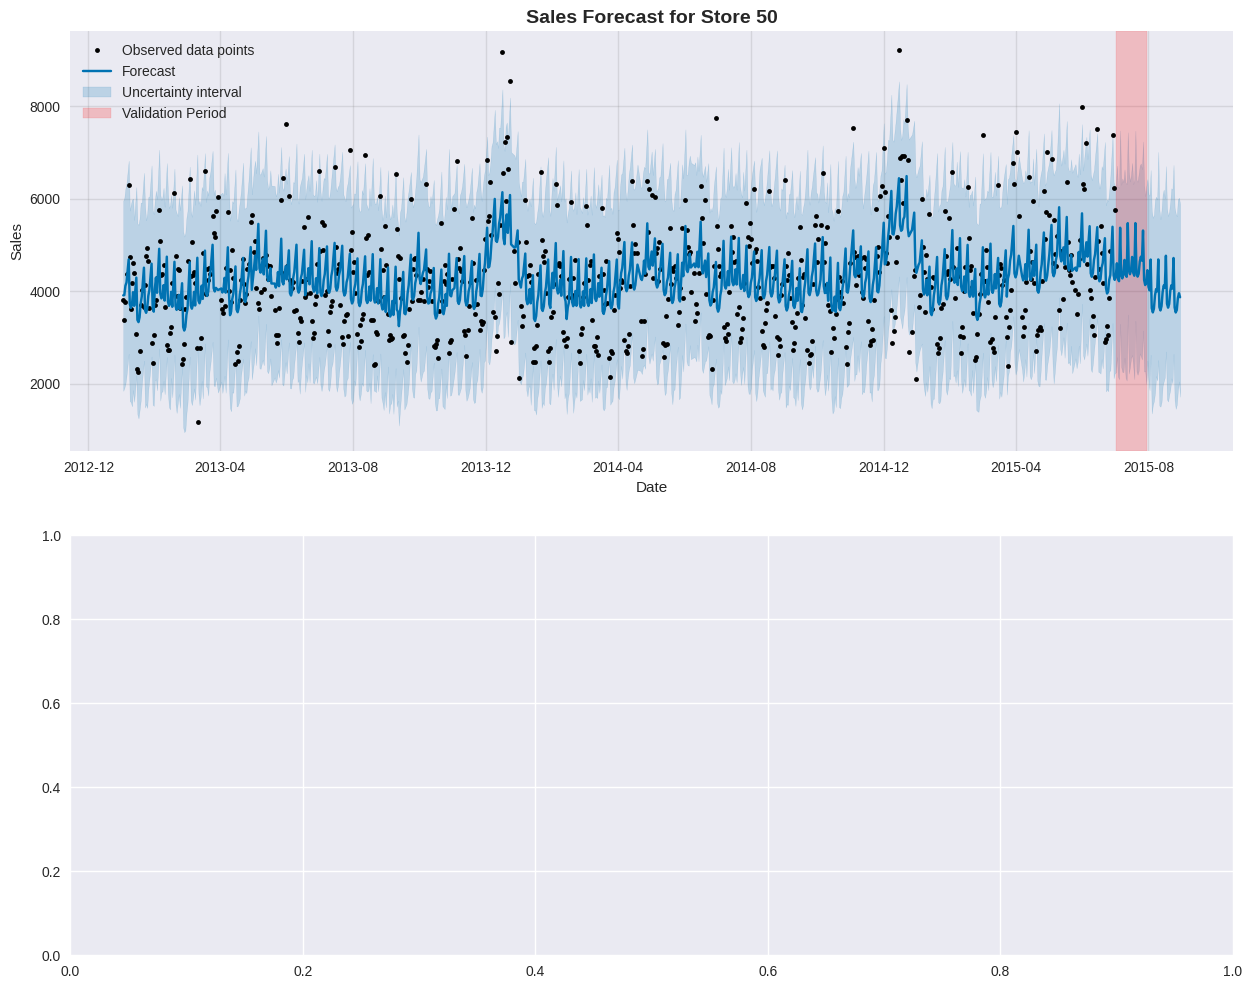

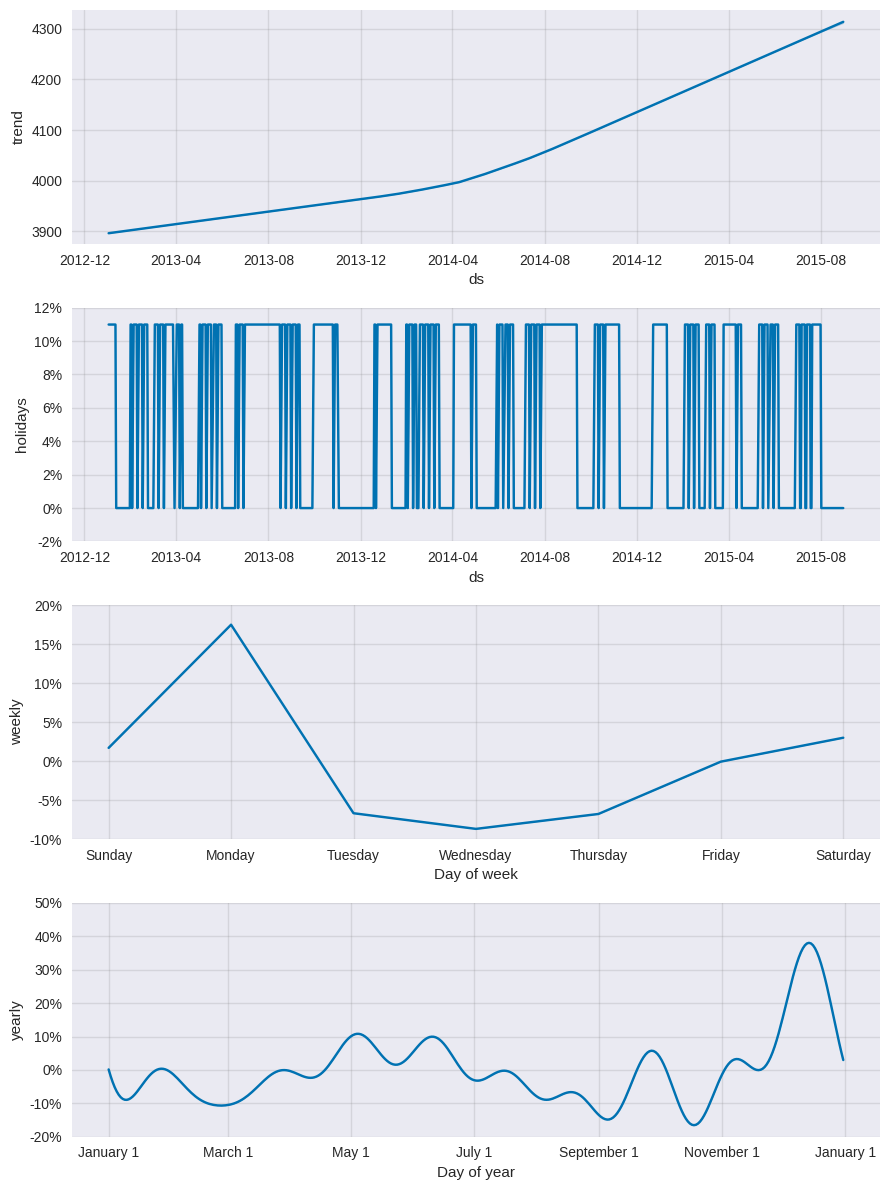

DEBUG:cmdstanpy:input tempfile: /tmp/tmprxxoul9p/p1lozsru.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprxxoul9p/pjm9eynj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33932', 'data', 'file=/tmp/tmprxxoul9p/p1lozsru.json', 'init=/tmp/tmprxxoul9p/pjm9eynj.json', 'output', 'file=/tmp/tmprxxoul9p/prophet_modelvrbkawu6/prophet_model-20250719215827.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:58:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



🔮 Forecasting for Store 100
----------------------------------------
📊 Data points available: 606
📅 Date range: 2013-01-02 00:00:00 to 2015-07-31 00:00:00
📈 Training data: 580 points
📉 Test data: 26 points
🤖 Training Prophet model...


21:58:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


📊 Validation Metrics:
  MAE:  4627.59
  RMSE: 5001.43
  MAPE: 59.62%


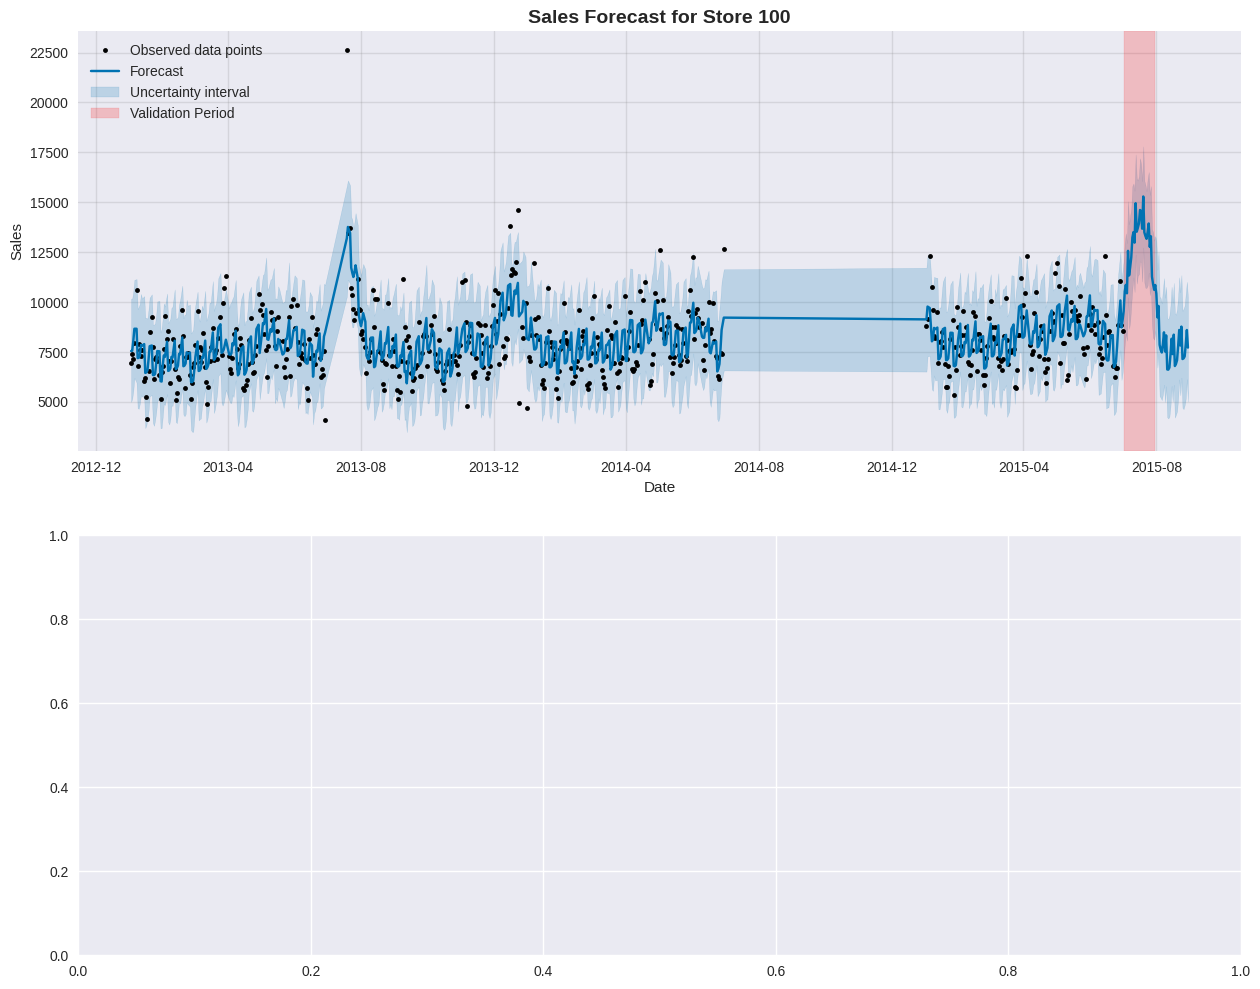

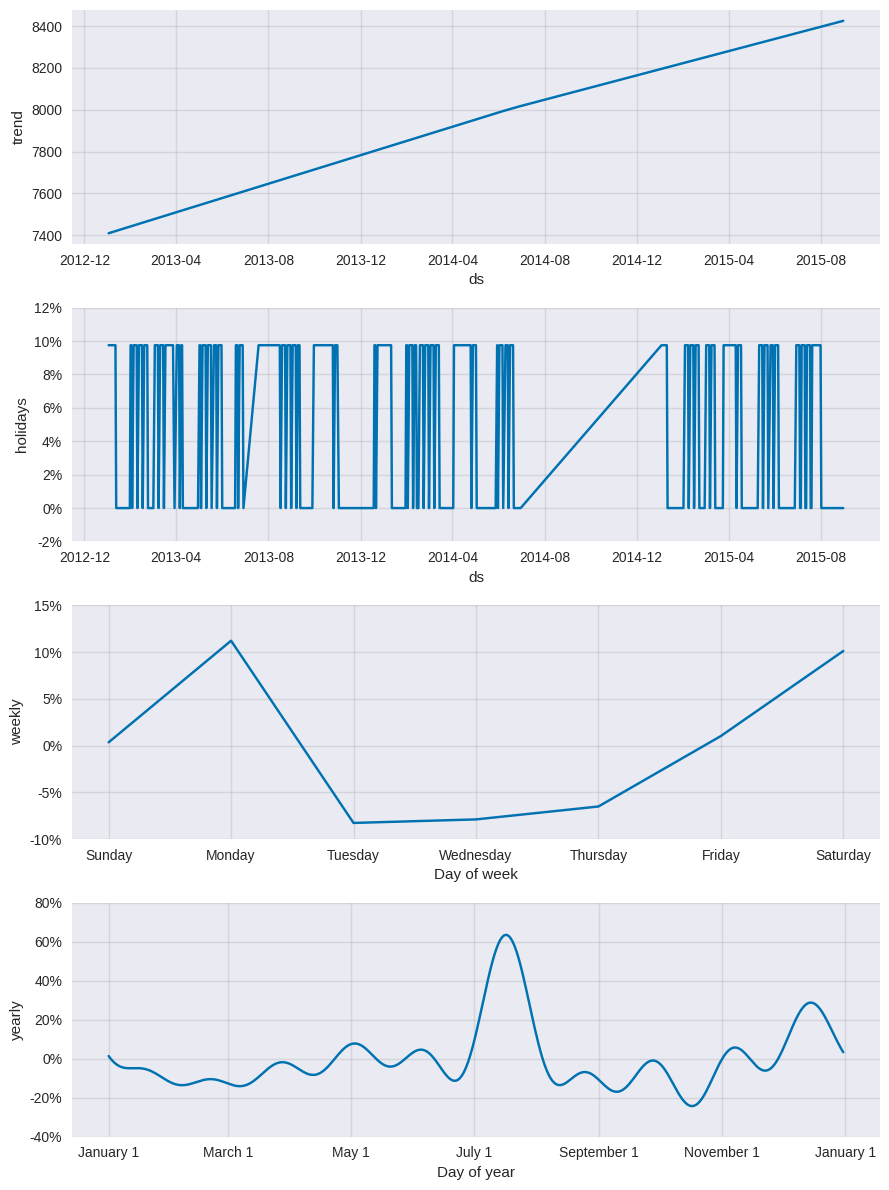

In [58]:

# Prepare holidays dataframe
print("\n🎄 Preparing holidays data...")
holidays_df = create_holidays_df(df)
print(f"✓ Created holidays dataframe with {len(holidays_df)} holiday dates")

# Example forecasts for different stores
sample_stores = [1, 10, 25, 50, 100]  # Sample store IDs
results = []

for store_id in sample_stores:
    if store_id in df['Store'].unique():
        result = sales_prediction_with_validation(store_id, df, holidays_df, 60)
        if result:
            results.append(result)
    else:
        print(f"❌ Store {store_id} not found in dataset")


# MODEL PERFORMANCE SUMMARY

In [59]:

if results:
    print("\n" + "="*60)
    print("MODEL PERFORMANCE SUMMARY")
    print("="*60)

    results_df = pd.DataFrame(results)

    print(f"\n📊 Summary Statistics across {len(results_df)} stores:")
    print(f"Average MAE:  {results_df['validation_mae'].mean():.2f}")
    print(f"Average RMSE: {results_df['validation_rmse'].mean():.2f}")
    print(f"Average MAPE: {results_df['validation_mape'].mean():.2f}%")

    print(f"\nForecast Statistics:")
    print(f"Average forecasted sales: {results_df['forecast_mean'].mean():.2f}")
    print(f"Forecast volatility (avg std): {results_df['forecast_std'].mean():.2f}")



MODEL PERFORMANCE SUMMARY

📊 Summary Statistics across 5 stores:
Average MAE:  1683.30
Average RMSE: 1966.41
Average MAPE: 24.16%

Forecast Statistics:
Average forecasted sales: 6814.09
Forecast volatility (avg std): 1098.60
